In [1]:
import os
import time
import yaml
import math
import pandas as pd
import numpy as np

In [2]:
from data.excel2pd import data_load
from data.preprocessing import data_preprocessing
from data.train_test_split import data2Window, X_Y2train_test, X_Y_from_data
from data.CustomDataset import CustomDataset

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
from model.model import seq2seq

In [4]:
# torch version, gpu 사용 여부, 이름 체크
print("torch version>>", torch.__version__)
print("GPU 사용 유무>>", torch.cuda.is_available())
if torch.cuda.is_available() :
    print("GPU 이름>> ", torch.cuda.get_device_name(0))
    device = "cuda:0" 
else :
    device = "cpu"
print(device)

torch version>> 1.13.1
GPU 사용 유무>> True
GPU 이름>>  NVIDIA GeForce RTX 2080
cuda:0


In [5]:
f = open("Settings.yaml", 'r')
setup = yaml.load(f, Loader=yaml.FullLoader)

data = data_load(11)
scaler, data = data_preprocessing(data, setup['data_options'])

X, Y = X_Y_from_data(data)

X_train, Y_train, X_test, Y_test = X_Y2train_test(X, Y,
                                                  setup['input_window'],
                                                  setup['output_window'],
                                                  setup['stride'])

In [6]:
dataset = CustomDataset(X_train, Y_train)
dataloader = DataLoader(dataset, batch_size = setup['batch'], shuffle = False)

In [7]:
model = seq2seq(input_window = setup['input_window'], 
output_window = setup['output_window'], 
input_size = 3, 
hidden_size = setup['LSTM'][0], 
num_layers = setup['num_layers'][0], 
dropout = setup['dropout']).to(device)

In [8]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 886 trainable parameters


In [11]:
model.train()

seq2seq(
  (encoder): Encoder(
    (lstm): LSTM(3, 5, num_layers=2, batch_first=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 5, num_layers=2, batch_first=True)
    (output_layer): Linear(in_features=5, out_features=1, bias=True)
    (dropout): Dropout(p=0, inplace=False)
  )
)

In [12]:
from model.train import train

model, optimizer = train(device = device, model = model, 
dataloader = dataloader, 
learning_rate = setup['learning_rate'], 
epoch = setup['epoch'],
output_window = setup['output_window'])

100%|██████████| 100/100 [11:08<00:00,  6.69s/it, loss=18.51079]


# save the model

In [13]:
#model save
import os
from datetime import datetime
#from model.train import save_model

now = datetime.now()
save_path = "./result/"+now.strftime('%Y_%m_%d_%H_%M')
try:
    if not os.path.exists(save_path) : 
        os.mkdir(save_path)
except:
    print("Error : Failed to create the directory.")

#save_model(save_path, model, optimizer)

# Test Section

In [14]:
from model.predict import predict

prediction = predict(model, X_test, setup['output_window'], scaler, setup['data_options']['CGM'], device)


# save the figures

[13.986608250935872, 10.257266426086426, 17.830436041294583, 13.888325606752353]


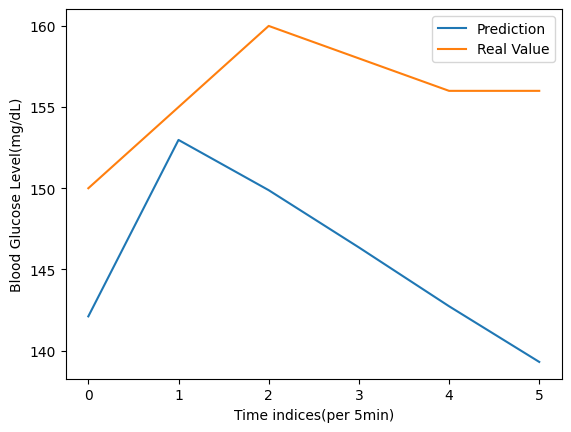

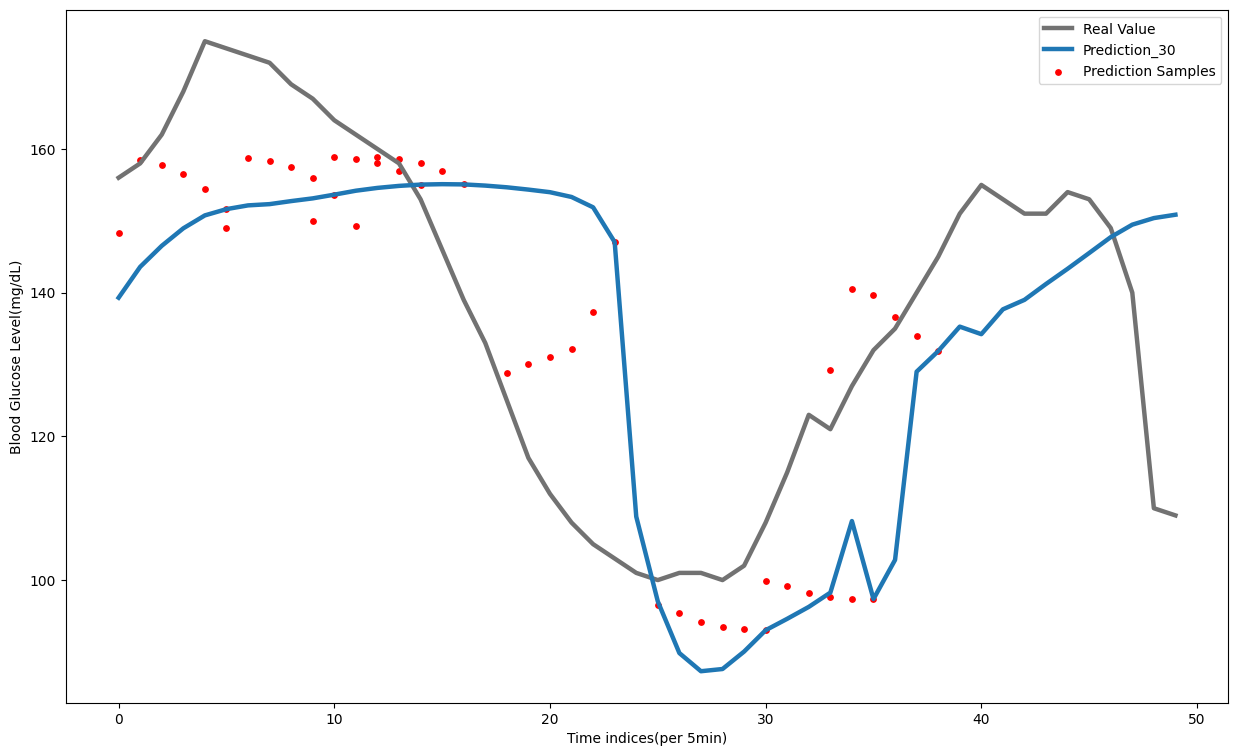

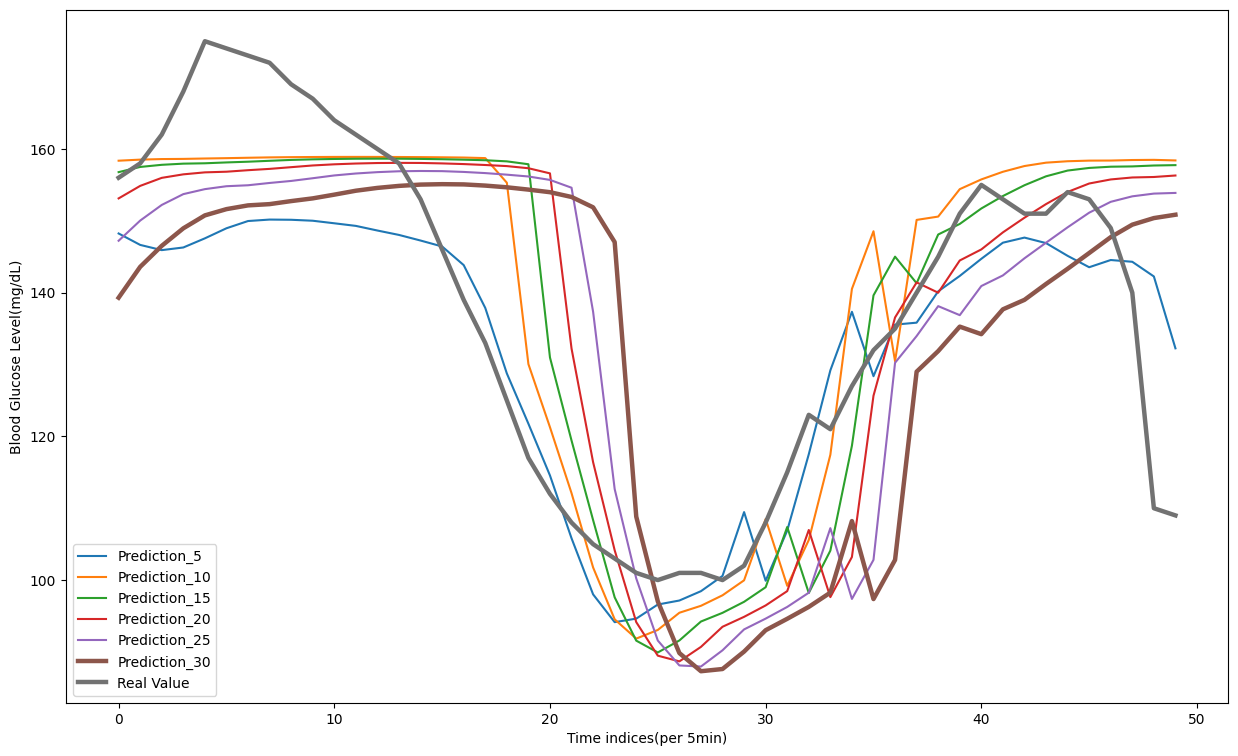

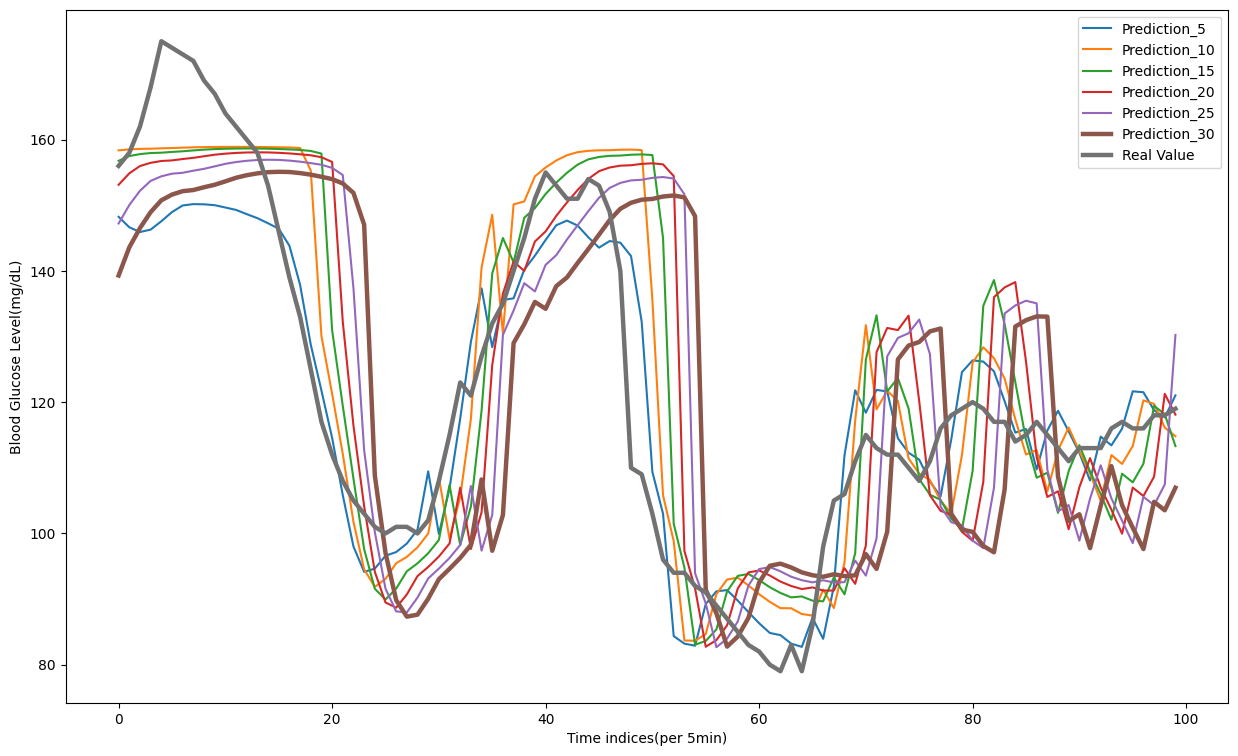

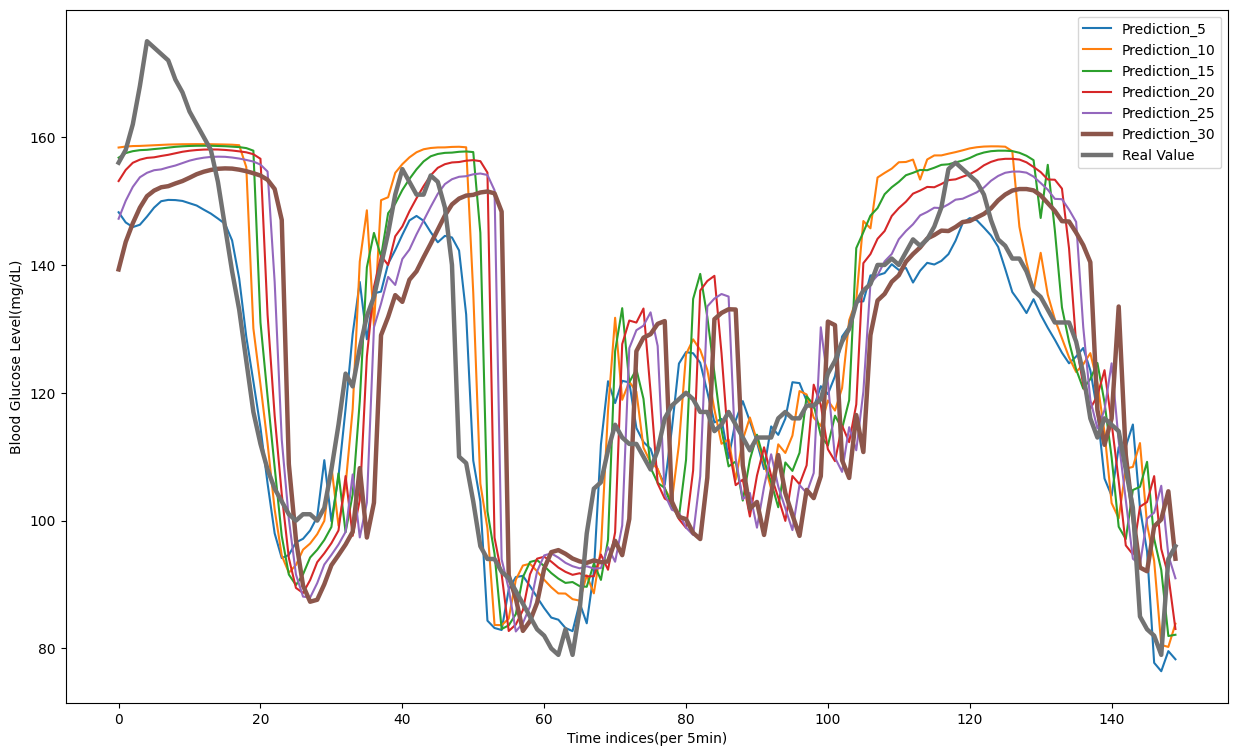

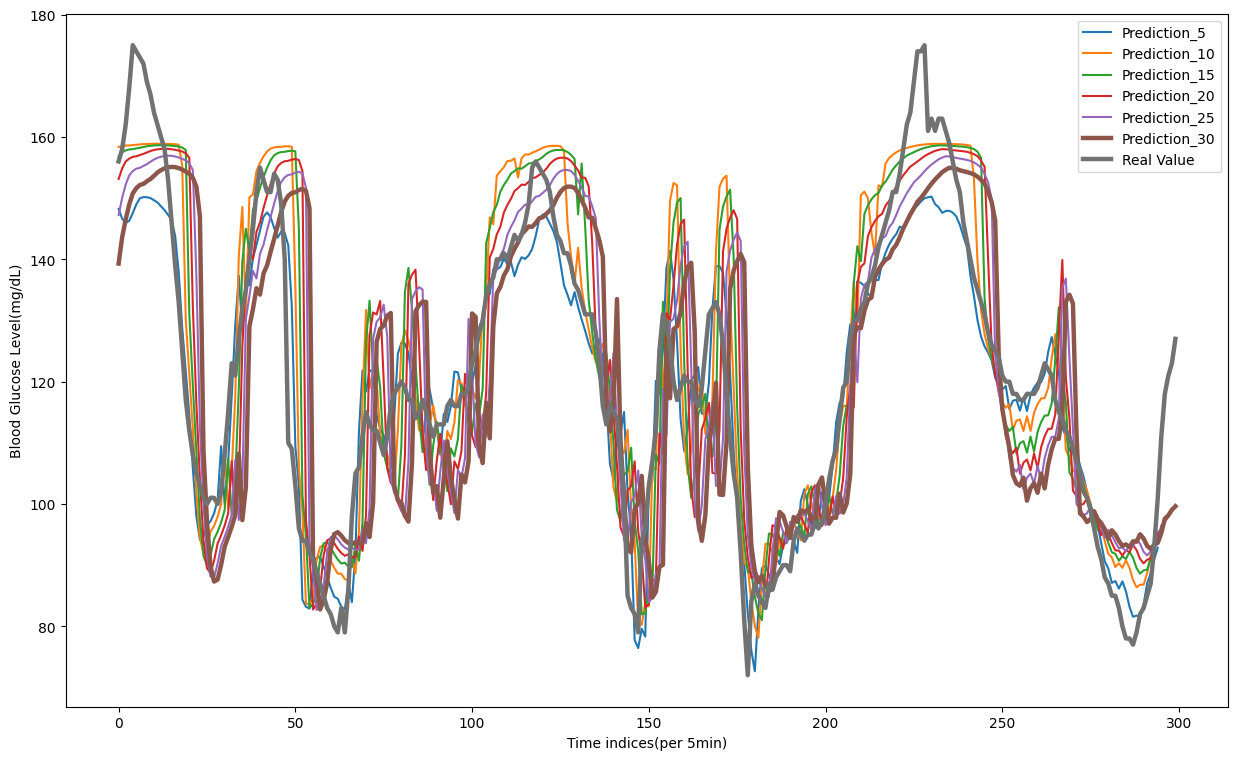

In [15]:
from model.result import result_jpg, save_yaml_and_error, save_numeric_result

result_jpg(prediction, Y_test, save_path)
save_yaml_and_error("./", save_path)
save_numeric_result(prediction, Y_test)